In [1]:
input_dim = 13
model_file = "Model/model.cpkt"
num_clusters = 4

import json
import matplotlib.pyplot as plt
from matplotlib.path import Path
import numpy as np
import os
import pandas as pd
import scipy
import tensorflow as tf

import sys
sys.path.insert(0, "../Code/")
from base import load_encoder
from explain_sync import explain, apply
from misc import eval_correctness

from data import load_data

def load_model(input_dim = input_dim, model_file = model_file):
    return load_encoder(input_dim, model_file)


In [2]:
###
# Load Data & Configuration
###

x, y = load_data()

with open("vertices.json") as json_file:  
    all_vertices = json.load(json_file)


INFO:tensorflow:Restoring parameters from Model/model.cpkt


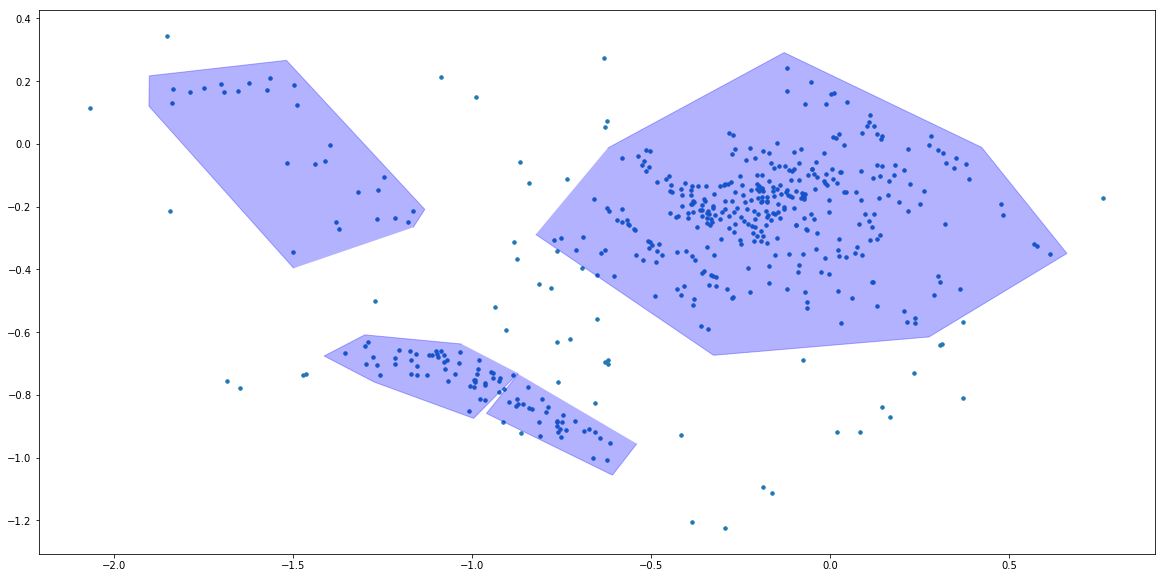

In [3]:
###
# Visualize the data and the marked clusters
###

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x, D: np.zeros((1, input_dim))})

fig, ax = plt.subplots(figsize=(20, 10))
patches = []

for i in range(num_clusters):
    line = plt.Polygon(all_vertices[i], closed=False, color="blue", alpha=0.3)
    ax.add_line(line)

plt.scatter(data_rep[:, 0], data_rep[:, 1], s = 12)

plt.show()
plt.close()

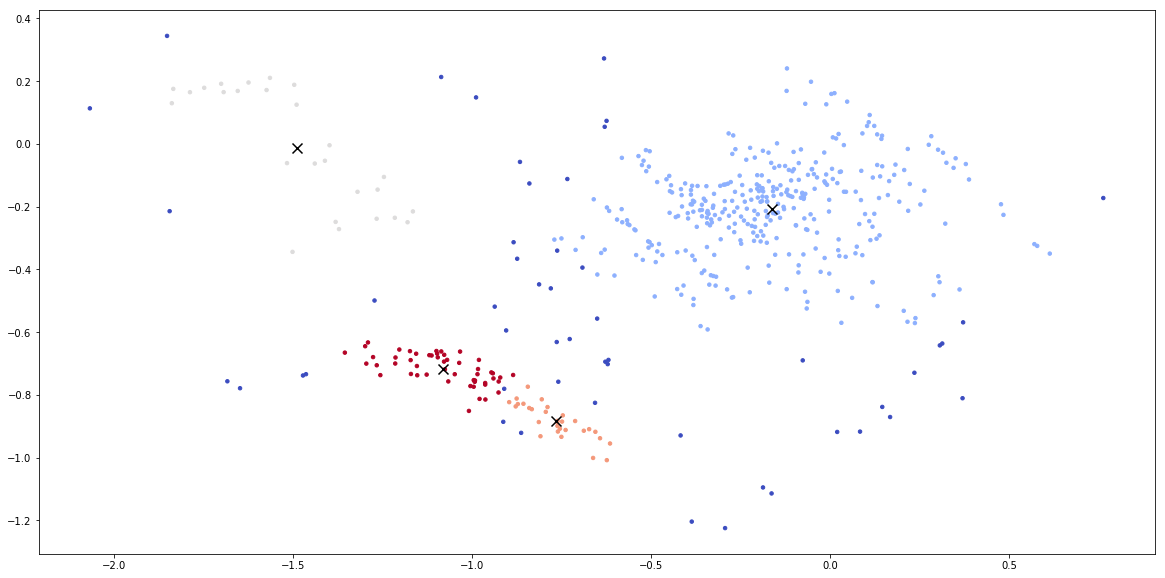

In [4]:
###
# Find the datapoints in each marked cluster
###

m = data_rep.shape[0]
cluster = -1.0 * np.ones((m))
indices = [[]] * num_clusters
centers = [[]] * num_clusters
for i in range(num_clusters):
    path = Path(all_vertices[i])
    indices[i] = []
    for j in range(m):
        if path.contains_points(data_rep[j].reshape((1,2))):
            cluster[j] = i
            indices[i].append(j)
    centers[i] = np.mean(data_rep[indices[i], :], axis = 0)
    
centers = np.array(centers)

fig, ax = plt.subplots(figsize=(20, 10))
patches = []
    
plt.scatter(data_rep[:, 0], data_rep[:, 1], s = 12, c = cluster, cmap = plt.cm.coolwarm)
plt.scatter(centers[:, 0], centers[:, 1], c = "black", marker = "x", s = 100)

plt.show()
plt.close()   

In [5]:
###
# Compute the cluster explanations
###

lambda_init = 0.25
factor = 1.1
threshold = 0.8

while True:
    os.system("rm -rf explanation")
    deltas = explain(load_model, x, data_rep, indices, dispersion = 0.0, lambda_global = lambda_init, num_points = 20)
    
    correctness = eval_correctness(load_model, x, indices, deltas, all_vertices)
    print(lambda_init, correctness)
    
    score = (np.sum(correctness) - num_clusters) / (num_clusters * num_clusters - num_clusters)
    print(score)
    if score < threshold:
        break
    else:
        lambda_init *= factor


INFO:tensorflow:Restoring parameters from Model/model.cpkt
0 0.10588206
398 0.10477397426641219
400 0.10314293035455295
1179 0.10109673977661254
1831 0.09513069029956205
INFO:tensorflow:Restoring parameters from Model/model.cpkt
0.25 [[1.         0.54022989 0.16666667 0.25862069]
 [1.         1.         0.73076923 0.69230769]
 [1.         0.7        1.         0.4       ]
 [1.         0.82352941 0.7254902  1.        ]]
0.6698011476916141



From  0  to  1 

INFO:tensorflow:Restoring parameters from Model/model.cpkt


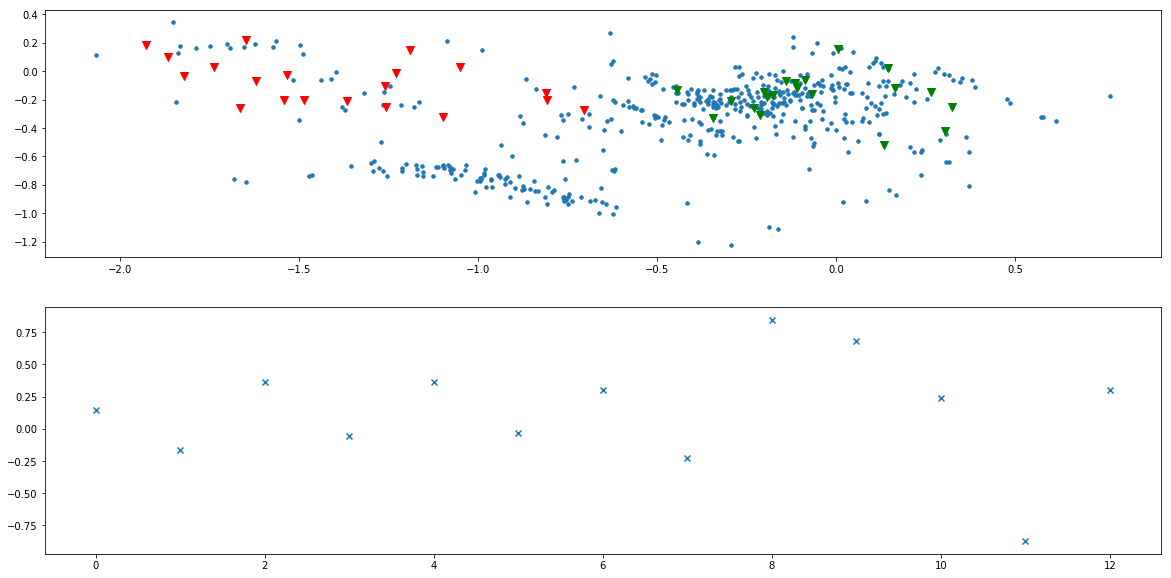


From  1  to  0 

INFO:tensorflow:Restoring parameters from Model/model.cpkt


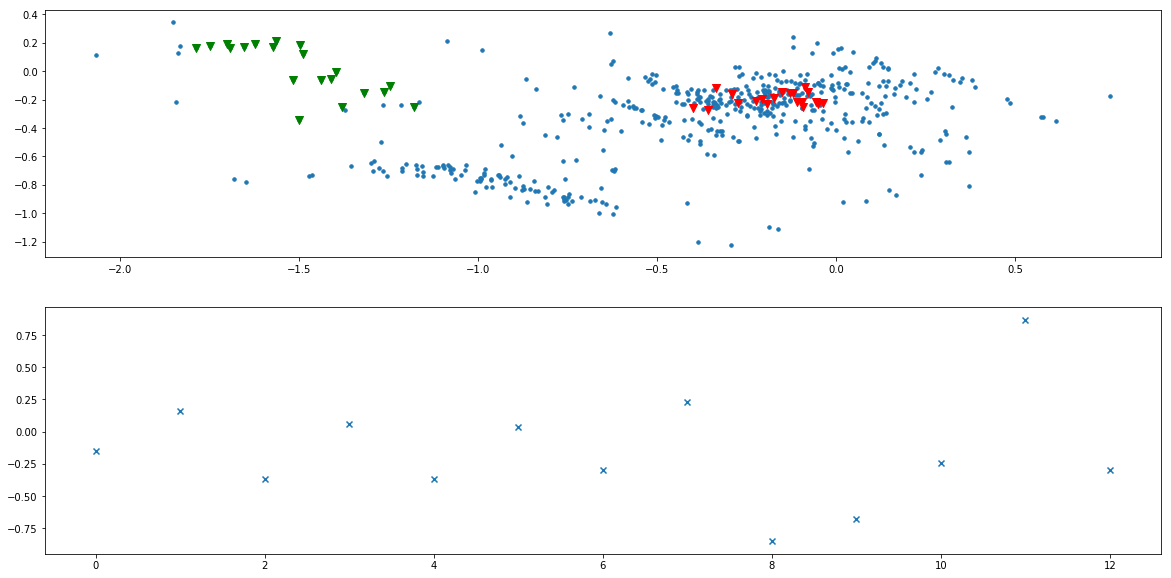


From  0  to  2 

INFO:tensorflow:Restoring parameters from Model/model.cpkt


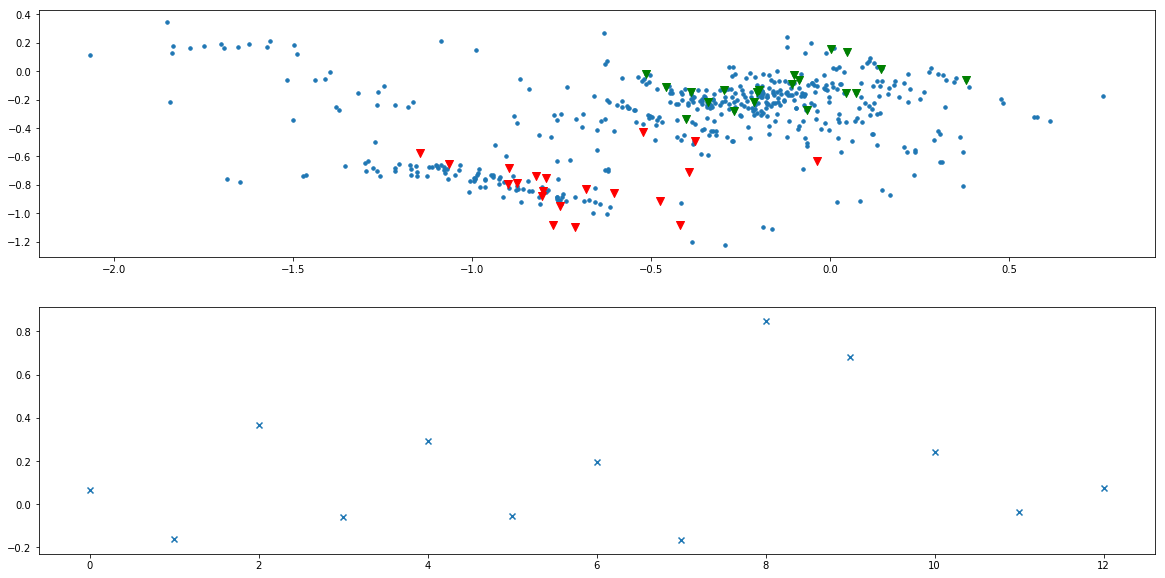


From  2  to  0 

INFO:tensorflow:Restoring parameters from Model/model.cpkt


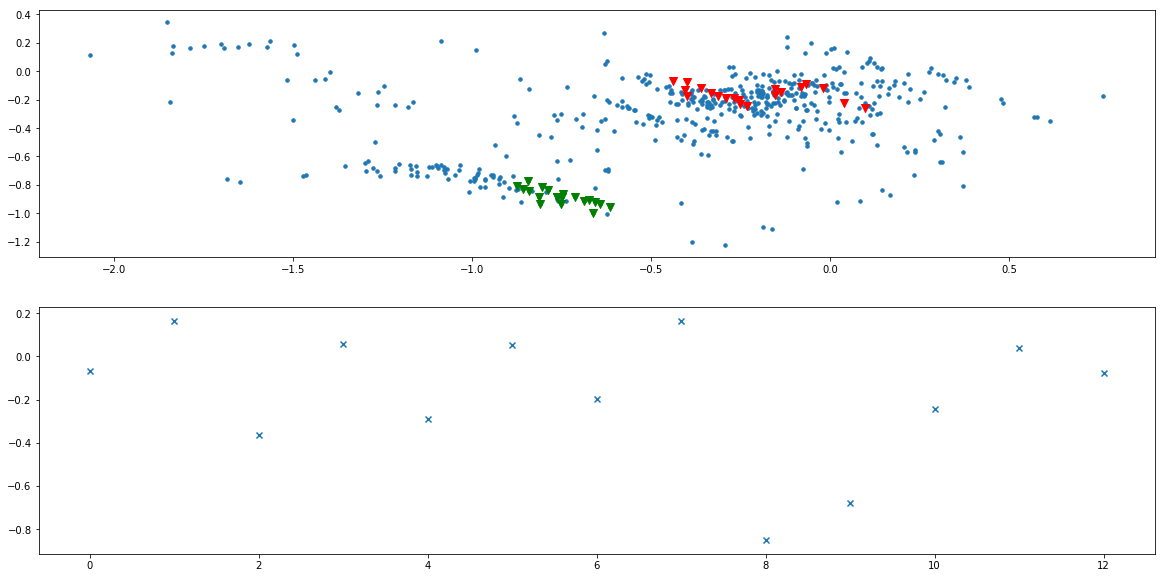


From  2  to  3 

INFO:tensorflow:Restoring parameters from Model/model.cpkt


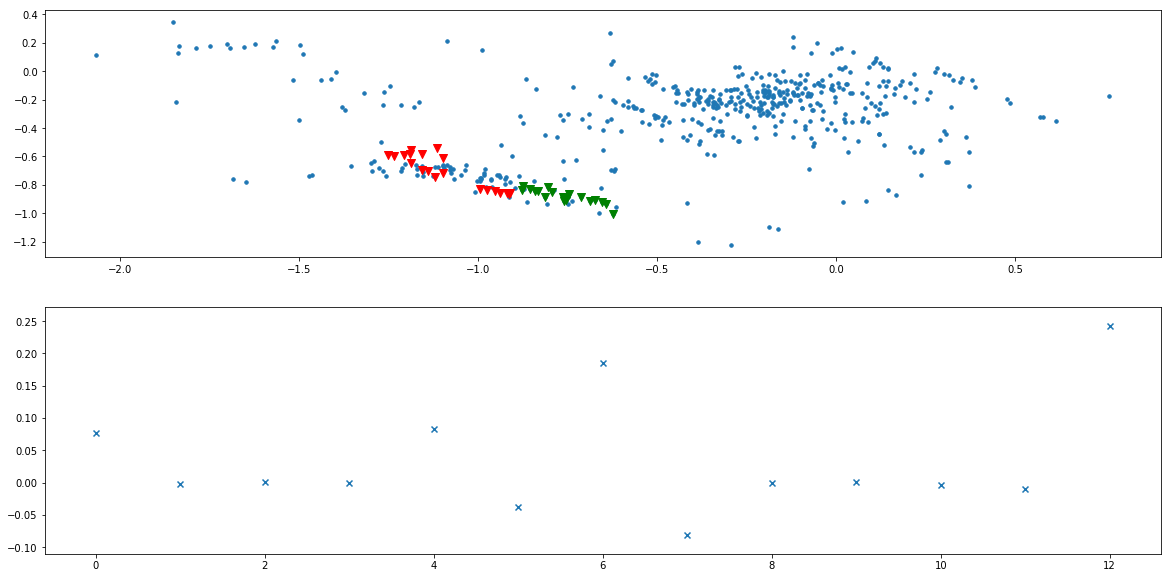


From  3  to  2 

INFO:tensorflow:Restoring parameters from Model/model.cpkt


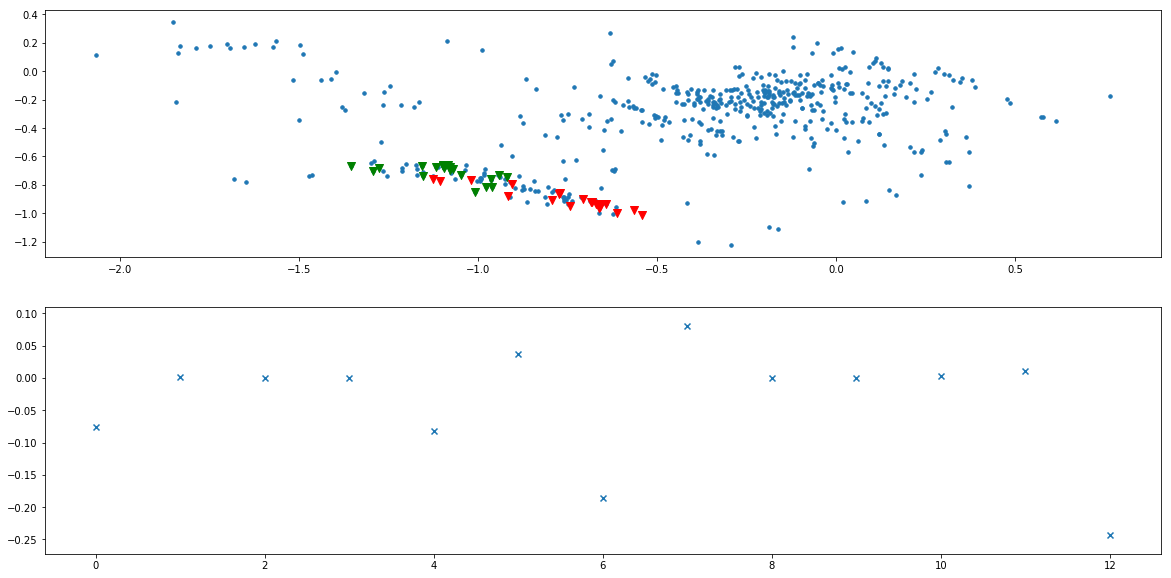

In [6]:
###
# Visualize the cluster explanations
###

def myplot(c1, c2):
    print("\nFrom ", c1, " to ", c2, "\n")
    
    if c1 == 0:
        d = deltas[c2 - 1]
    elif c2 == 0:
        d = -1.0 * deltas[c1 - 1]
    else:
        d = -1.0 * deltas[c1 - 1] + deltas[c2 - 1]
        
    apply(load_model, x, data_rep, indices, c1, np.reshape(d, (1, input_dim)), num_points = 20)
    
myplot(0, 1)
myplot(1, 0)
myplot(0, 2)
myplot(2, 0)

myplot(2, 3)
myplot(3, 2)
